In [2]:
# Created by: Arka Bhowmik and Sarah Eskreis-Winkler, 
# Memorial Sloan Kettering Cancer Center, NY (2022)
# --------------------------------------------------------------------------------------
# THIS IS THE MAIN PROGRAM FOR TRAINING 2D U-Net SEMANTIC SEGMENTATION 
# TRAINED U-NET MODELS CREATES MASK FOR THE INPUT IMAGE. FOR TRAINING INPUT SHOULD HAVE
# TRUE IMAGE AND ITS MASKS (IMAGE MASKS CAN BE CREATED BY ITK SNAP OR MATLAB)
# 
# THE MODELS INCLUDES VARIOUS SUB-FUNCTIONS
# INSTRUCTIONS: ENSURE ALL SUBFUNCTIONS AND MAIN PROGRAM IN THE SAME FOLDER 
#               OR CHANGE THE PATH INSIDE ACCORDINGLY
#--------------------------------------------------------------------------------------
# IMPORT IMPORTANT TENSORFLOW AND KERAS LIBRARIES TO RUN DEEP CNN
#
import tensorflow as tf
import tensorflow_addons as tfa
#
# SUPPORTING LIBRARIES
import os
import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm
#
# STOPS WARNING AND CHECKS FOR TENSORFLOW VERSION
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#

In [3]:
#******************************************************************
#                  STEP 1: USER MODEL INPUTS
#******************************************************************
# Add path for suppoting functions
sys.path.append('/data/sutton/Arka/CNN_code/Segmentation_prog/support_func/')
#
# CHANGE ALL INPUT PARAMETERS ONLY IN config_unet.PY (can be found in support_func)
import config_unet as config
#
from read_and_split_unet import read_and_split              # Calls the function for spliting the dataset into training and valid set
from create_dictionary_unet import create_dictionary        # Calls the function for creating a dictionary
from Data_gen_unet import DataGenerator                # Calls the function for datageneration
from custom_model_unet import unet                          # Calls the function for u-net model
from custom_metrics import dice_loss, IoU_acc, dice_bce_loss
                                                            # Calls custom metrics for dice_coeff, Intesection_over_union, 
                                                            # ensemble of cross_entropy and dice_coeff
#

In [4]:
#
#-----------------------------------------------------------------------------
#                  STEP 2: DATA PRE-PROCESSING
#-----------------------------------------------------------------------------
#
# THE DATA PRE-PROCESSING STEP READ AND SPLIT DATA INTO TRAIN AND VALID SETS
# (IF TRAIN AND VALID ALREADY EXISTS IN THE PATH--> Put split_flg='nosplit'
# 
#******************************************************************************
# USER INSTRUCTION:- THIS STEP WILL REPLACE THE EARLIER TRAIN AND VALID FILES
# (If split_flg = 'split')
#******************************************************************************
#
read_and_split(config.BASE_PATH,config.CSV_NOTSPLIT,config.split_ID,
               config.train_ratio,config.validation_ratio,config.split_flg)
#

NO SPLIT PERFORMED SINCE TRAIN & VALID SET ALREADY EXIST



In [5]:
#
#-----------------------------------------------------------------------------
#                          STEP 3: DATA GENERATION
#-------------------------------------------------------------------------------
#
# THIS IS A CUSTOM DATA GENERATION STEP
# 
params = {
    'batch_size': config.BATCH_SIZE,                  # DEFINE BATCH SIZE
    'dim': (config.IMAGE_SIZE, config.IMAGE_SIZE),    # DEFINE IMAGE WIDTH AND HEIGHT
    'n_channels': config.IMAGE_CHANNELS,              # DEFINE THE INPUT CHANNELS TO THE NETWORK
    'shuffle': config.SHUFF,                          # SHUFFLE DATASET EACH EPOCH
    'imgsize':config.IMAGE_SIZE}                      # IMAGE SIZE
#
#---------------------------------------------------------------
# CREATING DICTIONARY FILES FOR TRAINING AND VALIDATION SET
#---------------------------------------------------------------
#
partition_tr, impath_tr, mask_tr = create_dictionary(config.train_filename, config.BASE_PATH, 'None')
partition_vl, impath_vl, mask_vl = create_dictionary(config.valid_filename, config.BASE_PATH, 'None')   
#
#-------------------------------------------------------------------------------
# DATA GENERATORS FOR TRAINING AND VALIDATION SETS
#-------------------------------------------------------------------------------
#
training_generator = DataGenerator(partition_tr, impath_tr, mask_tr, **params)
validation_generator = DataGenerator(partition_vl, impath_vl, mask_vl, **params)
#

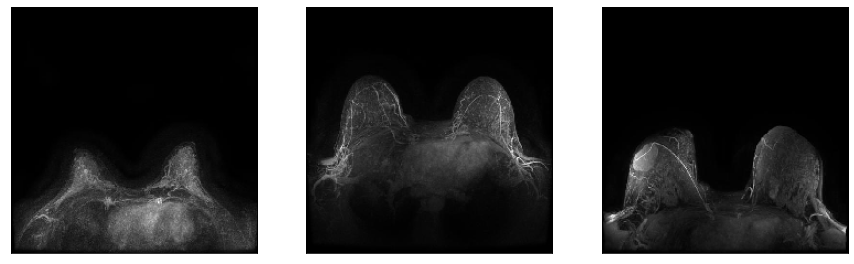

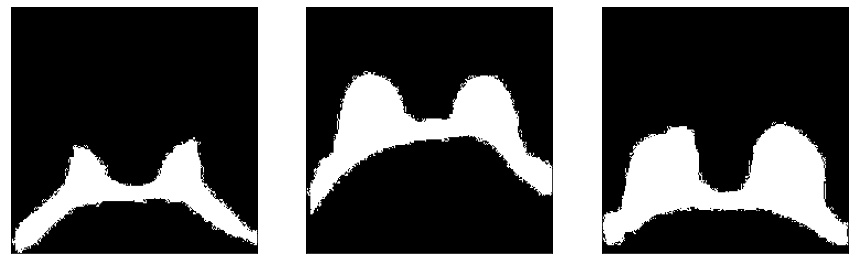

In [6]:
#-----------------------------------------------------------------------------
#                          STEP 3A: DISPLAY DATA GENERATION FILE
#-------------------------------------------------------------------------------
# Visualize the train/valid datagenrator images 
#
plt.figure(figsize=(15, 15));
idx=0
for X, Y in validation_generator:
    for i in range(3): # range(3) only work since batch size is 3
        plt.subplot(1,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((X[i]), cmap='gray')
        #
    #
    idx=idx+1
    #
    if idx > 3:
        break
    #
#
plt.figure(figsize=(15, 15));
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((Y[i]), cmap='gray')
#

In [8]:
#
#******************************************************************
#          STEP 4: CREATE A CUSTOM U-NET MODEL
#******************************************************************
#
model=unet(config.IMAGE_SIZE, config.IMAGE_CHANNELS)
#

In [9]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 640         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_19[0][0]                  
______________________________________________________________________________________________

In [ ]:
#***********************************************************************
#           STEP 5: COMPILE THE MODEL AND SHOW SUMMARY
#***********************************************************************
#
opt = tf.keras.optimizers.Adam(learning_rate=config.INIT_LR)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[dice_loss, IoU_acc, dice_bce_loss])
#

In [ ]:
#
#----------------------------------------------------------------------------------------
#                         STEP 6: TRAINING
#----------------------------------------------------------------------------------------
# USER DEFINED CALL BACK AND CHECK POINT FUNCTIONS
# 1. CALL BACK: STOPS IF VAL_LOSS DOES NOT MINIMIZES FOR 25 CONSECUTIVE EPOOCHS
# 2. CHECKPOINT: SAVES THE BEST MODEL WITH MAXIMUM VALIDATION ACCURACY
# 3. CALL BACK OPTIONS: REDUCE THE LEARNING RATE IF VALID_LOSS DID NOT REDUCE THREE CONSEQUTIVE EPOOCHS
checkpoint_filepath = 'u_net_models/'+ 'model_' + config.h5file_name + '_{epoch:02d}_loss_{val_loss:.3f}.h5'
my_callbacks = [
    tfa.callbacks.TQDMProgressBar(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(config.BASE_OUTPUT, checkpoint_filepath), 
                                       monitor='val_loss', verbose=1, mode='min', 
                                       save_best_only=True, save_freq="epoch")]
#
start = time.time()
#
train_history = model.fit(training_generator, validation_data=validation_generator,
                          epochs = config.NUM_EPOCHS, callbacks=[my_callbacks],
                          verbose = 0, initial_epoch=0, workers=4, use_multiprocessing=True)
#
#
stop = time.time()
#
print(f"Training time: {stop - start}s")
#

In [ ]:
#-------------------------------------------------------------------------------------------
#
#                  STEP 7: STORING THE TRAINING DATA
#-------------------------------------------------------------------------------------------
# STORES THE DETAILS IN A FILE
my_acc_train = train_history.history['accuracy']  # Stores the training accuracy
my_loss_train = train_history.history['loss']     # Stores the training loss
my_acc_valid = train_history.history['val_accuracy']   # Stores the validation accuracy
my_loss_valid = train_history.history['val_loss']      # Stores the validation loss
#
# SAVES TO A CSV FILE
#filename_train='ACC_LOSS_EPOCH_TRAIN_' + config.h5file_name + '.csv'
#filename_valid='ACC_LOSS_EPOCH_VALID_' + config.h5file_name + '.csv'
#np.savetxt(os.path.join(config.BASE_OUTPUT, filename_train), 
#           np.column_stack([my_acc_train, my_loss_train]), fmt='%s', 
#           delimiter=",", header="TRAIN_ACCU,TRAIN_LOSS", comments='')
#np.savetxt(os.path.join(config.BASE_OUTPUT, filename_valid), 
#           np.column_stack([my_acc_valid, my_loss_valid]), fmt='%s', 
#           delimiter=",", header="VALID_ACCU,VALID_LOSS", comments='')
#

In [ ]:
#------------------------------------------------------------------------------------
#                  STEP 8: PLOT THE ACCURACY AND LOSS WITH EPOCH
#-----------------------------------------------------------------------------------
#
if config.plot_ACC_LOSS=='Y':
    #------------------------------------------------------------------------------------------
    #                         STEP 7: PLOTTING STEPS
    #                         (THIS STEP IS OPTIONAL)
    fig_name='PLOT_ACC_LOSS_' + config.h5file_name + '.png' 
    #
    def plot_acc_loss(train_history, epochs):
        acc = train_history.history['accuracy']
        loss = train_history.history['loss']
        val_acc = train_history.history['val_accuracy']
        val_loss = train_history.history['val_loss']
        plt.figure(figsize=(15, 5))
        plt.subplot(121)
        plt.plot(range(1,epochs), acc[1:], label='Train_acc')
        plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
        plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
        plt.xlabel('Epochs', size = 14)
        plt.ylabel('Accuracy', size = 14)
        plt.legend()
        plt.grid(True)
        plt.subplot(122)
        plt.plot(range(1,epochs), loss[1:], label='Train_loss')
        plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
        plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
        plt.xlabel('Epochs', size = 14)
        plt.ylabel('Loss', size = 14)
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(config.BASE_OUTPUT, fig_name))
        return()
    # CALL THE PLOT FUNCTION
    plot_acc_loss(train_history, config.NUM_EPOCHS)  # Specify the number of epoch (since training stopped earlier)
    #
elif config.plot_ACC_LOSS=='N':
    pass
#
#------------------------
# END OF PROGRAM
#-----------------------